# Overexpression and downregulation targets for lycopene production

We want to know which reactions, if overexpressed or downregulated, affect lycopene production. This will require going through all the reactions to see whether they affect lycopene production or are affected by it. Using flux scanning based enforced objective flux (FSEOF) it is possible to see which fluxes increase or decrease as the product flux increases. This method has been validated for lycopene production in $\textit{E. coli}$ as FSEOF accuretly predicted increased lycopene production when certain genes were over expressed  (Choi et al., 2010). We start with importing a FSEOF algorithm from the cameo package and importing our yeast model with the heterologous pathway.

In [1]:
from cameo.strain_design.deterministic.flux_variability_based import FSEOF
from cobra.io import read_sbml_model

model = read_sbml_model('models/yeast_lyco.xml')
medium=model.medium

In [2]:
fseof = FSEOF(model)

Here we use the FSEOF algorithm to identify the reactions affected by varied lycopene flux:

In [3]:
sol=fseof.run(target=model.reactions.get_by_id("CrtI"))
df=sol.data_frame;

In [4]:
df

,1,2,3,4,5,6,7,8,9,10
r_0024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003360
r_0091,0.144106,0.227637,0.311168,0.394700,0.478231,0.561762,0.408665,0.222283,0.035901,0.000000
r_0103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020691
r_0104,0.079718,0.140907,0.202095,0.263283,0.324471,0.385659,0.446658,0.507637,0.568617,0.608757
r_0215,0.021356,0.019423,0.017490,0.015556,0.013623,0.011689,0.017094,0.013151,0.009209,0.083657
...,...,...,...,...,...,...,...,...,...,...
r_4216,-0.000001,-0.000001,-0.000001,-0.000001,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
r_4262,0.106875,0.097199,0.087524,0.077848,0.068173,0.058497,0.040055,0.030816,0.021578,0.011548
r_4460,-0.262000,-0.272483,-0.282967,-0.293450,-0.303933,-0.314416,-0.322329,-0.329985,-0.337641,-0.343268
CrtB,0.007841,0.015682,0.023522,0.031363,0.039204,0.047045,0.054886,0.062726,0.070567,0.078408


There are 110 reaction fluxes affected as visualized below. Many of these are not valuable targets for gene manipulation and in the following sections we will try to extract the most obvious candidates.

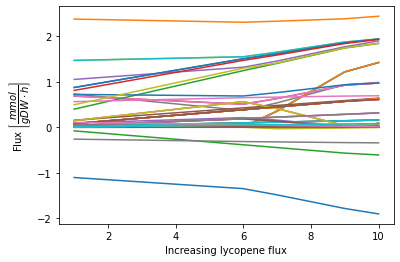

In [5]:
from matplotlib import pyplot as plt
plt.plot(df.T);
plt.xlabel("Increasing lycopene flux");
plt.ylabel(r"Flux $\left[\dfrac{mmol}{gDW\cdot h}\right]$");

## Down regulation targets

To find downregulation targets we want to look at reactions that decrease in flux as lycopene flux increases. So we weed out those values. We also want a significant change in flux, a significant flux overall and ignore values that have no flux to start with (which is done with the code below). Since there are many reactions, it is prudent for this analysis to exclude a lot of the less significant ones. This is done to find the most impactful reactions. When designing a cell factory it is not easy to make a lot of changes. This analysis is not sourced from publications, however an experimentally validated analysis is done in the next section.

In [6]:
Keys = []
for row in range(len(df[1])):
        if df[1][row]==0.0:
            continue
        elif df[1][row]>df[10][row] and abs(df[1][row]-df[10][row])/abs(df[1][row])>0.5 and df[1][row]-df[10][row]>0.1:
            Keys.append(df.index[row])
Reactions=df.T[Keys].T.sort_values(by=[10])
Reactions

,1,2,3,4,5,6,7,8,9,10
r_1696,-1.104889,-1.153733,-1.202576,-1.251419,-1.300263,-1.349106,-1.486267,-1.635465,-1.784662,-1.904454
r_1840,-0.079718,-0.140907,-0.202095,-0.263283,-0.324471,-0.385659,-0.446658,-0.507637,-0.568617,-0.608757
r_0091,0.144106,0.227637,0.311168,0.394700,0.478231,0.561762,0.408665,0.222283,0.035901,0.000000
r_0466,0.144106,0.227637,0.311168,0.394700,0.478231,0.561762,0.408665,0.222283,0.035901,-0.000000
r_0889,0.144106,0.227637,0.311168,0.394700,0.478231,0.561762,0.408665,0.222283,0.035901,-0.000000


Here we plot the results:

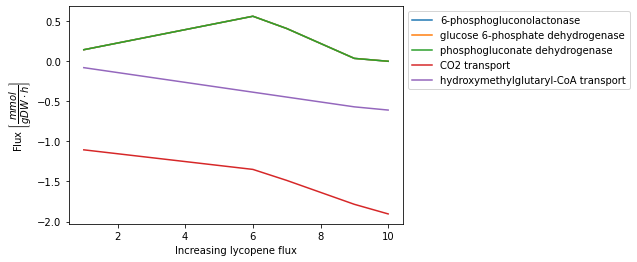

In [7]:
for k in Keys:
    plt.plot(Reactions.T[k],label=model.reactions.get_by_id(k).name)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Increasing lycopene flux");
plt.ylabel(r"Flux $\left[\dfrac{mmol}{gDW\cdot h}\right]$");

This analysis yields three downregulation targets, which direct carbon to the pentose-phosphate pathway. This might explain why intially they increase in flux and eventually fall to no flux, since at optimal lycopene production there is no biomass production. So in reality, they are not downregulation targets, since then there would be no biomass production. Choi et al., 2010, suggested that directing flux away from the pentose-phosphate pathway increases lycopene yield. Meanwhile the transport reactions are usually defined as negative fluxes (so even though they decrease in flux it is an increased negative flux), so we need to increase these fluxes. Below the reactions are listed in more detail.

In [8]:
for id in Reactions.index:
    r=model.reactions.get_by_id(id)
    print(r.name, id+",","final flux:", Reactions.T[id][10])
    s=""
    for rea in range(len(r.reactants)):
        if rea==len(r.reactants)-1:
            s+=r.reactants[rea].name+" ==> "
        else:
            s+=r.reactants[rea].name+" + "
    for p in range(len(r.products)):
        if p==len(r.products)-1:
            s+=r.products[p].name
        else:
            s+=r.products[p].name+" + "
    print(s)
    print()

CO2 transport r_1696, final flux: -1.904454
carbon dioxide [cytoplasm] ==> carbon dioxide [mitochondrion]

hydroxymethylglutaryl-CoA transport r_1840, final flux: -0.608757
3-hydroxy-3-methylglutaryl-CoA [cytoplasm] ==> 3-hydroxy-3-methylglutaryl-CoA [mitochondrion]

6-phosphogluconolactonase r_0091, final flux: 0.0
6-O-phosphono-D-glucono-1,5-lactone [cytoplasm] + H2O [cytoplasm] ==> 6-phospho-D-gluconate [cytoplasm] + H+ [cytoplasm]

glucose 6-phosphate dehydrogenase r_0466, final flux: -0.0
D-glucose 6-phosphate [cytoplasm] + NADP(+) [cytoplasm] ==> 6-O-phosphono-D-glucono-1,5-lactone [cytoplasm] + H+ [cytoplasm] + NADPH [cytoplasm]

phosphogluconate dehydrogenase r_0889, final flux: -0.0
6-phospho-D-gluconate [cytoplasm] + NADP(+) [cytoplasm] ==> carbon dioxide [cytoplasm] + D-ribulose 5-phosphate [cytoplasm] + NADPH [cytoplasm]



## Overexpression targets

Based on what Choi et al. did in $\textit{E. coli}$, it is possible to sort out the potential targets for overexpression. They used the criteria:

$$|v_j^{max}|>|v_j^{initial}| \quad v_j^{max}*v_j^{initial}\geq 0$$

where $v_j$ is the flux of the reaction j, $v_j^{max}$ is the maximal flux and $v_j^{intial}$ is the intial flux, while varying lycopene flux from low to high. Choi et al implemented the overexpression targets in $\textit{E. coli}$ with positive results, ie. the titer increased.

In [19]:
Keys = []
for row in range(len(df[1])):
    if abs(df[1][row])<abs(max(df.T[df.T.keys()[row]])) and df[1][row]*max(df.T[df.T.keys()[row]]):
        Keys.append(df.index[row])

Sorting the list by final flux:

In [20]:
Reactions=df.T[Keys].T.sort_values(by=[10])

In [27]:
Keys=Reactions.index

Plotting the resulting reactions:

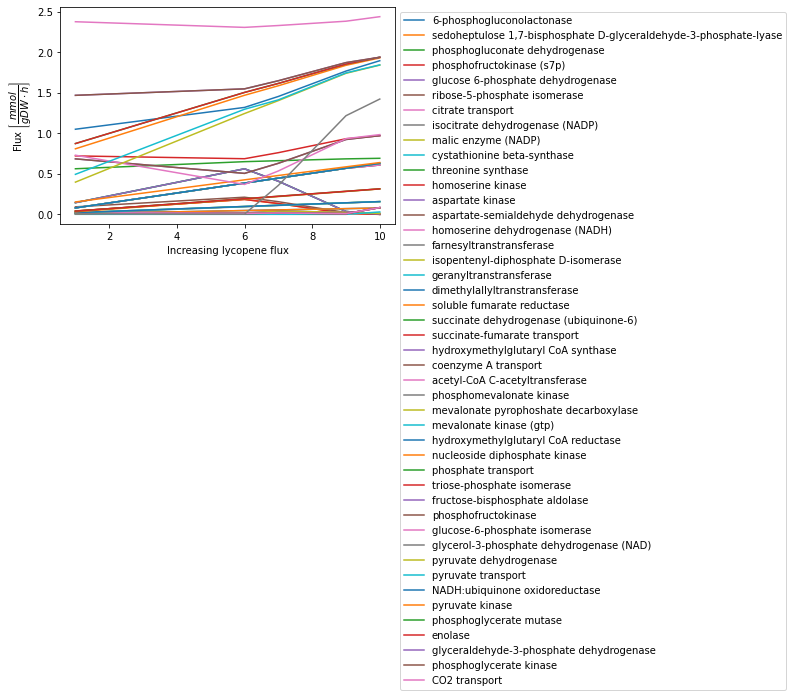

In [24]:
for k in Keys:
    plt.plot(Reactions.T[k],label=model.reactions.get_by_id(k).name)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Increasing lycopene flux");
plt.ylabel(r"Flux $\left[\dfrac{mmol}{gDW\cdot h}\right]$");

These criteria yield a total of 47 potential reactions that can be overexpressed. Below is a list of each reaction with a little more details.

In [25]:
for id in Reactions.index:
    r=model.reactions.get_by_id(id)
    print(r.name, id+",","final flux:", Reactions.T[id][10])
    s=""
    for rea in range(len(r.reactants)):
        if rea==len(r.reactants)-1:
            s+=r.reactants[rea].name+" ==> "
        else:
            s+=r.reactants[rea].name+" + "
    for p in range(len(r.products)):
        if p==len(r.products)-1:
            s+=r.products[p].name
        else:
            s+=r.products[p].name+" + "
    print(s)
    print()

6-phosphogluconolactonase r_0091, final flux: 0.0
6-O-phosphono-D-glucono-1,5-lactone [cytoplasm] + H2O [cytoplasm] ==> 6-phospho-D-gluconate [cytoplasm] + H+ [cytoplasm]

sedoheptulose 1,7-bisphosphate D-glyceraldehyde-3-phosphate-lyase r_0990, final flux: -0.0
sedoheptulose 1,7-bisphosphate [cytoplasm] ==> D-erythrose 4-phosphate [cytoplasm] + dihydroxyacetone phosphate [cytoplasm]

phosphogluconate dehydrogenase r_0889, final flux: -0.0
6-phospho-D-gluconate [cytoplasm] + NADP(+) [cytoplasm] ==> carbon dioxide [cytoplasm] + D-ribulose 5-phosphate [cytoplasm] + NADPH [cytoplasm]

phosphofructokinase (s7p) r_0887, final flux: 0.0
ATP [cytoplasm] + sedoheptulose 7-phosphate [cytoplasm] ==> ADP [cytoplasm] + H+ [cytoplasm] + sedoheptulose 1,7-bisphosphate [cytoplasm]

glucose 6-phosphate dehydrogenase r_0466, final flux: -0.0
D-glucose 6-phosphate [cytoplasm] + NADP(+) [cytoplasm] ==> 6-O-phosphono-D-glucono-1,5-lactone [cytoplasm] + H+ [cytoplasm] + NADPH [cytoplasm]

ribose-5-phosphat

A lot of the reactions above are related to the central metabolism, as the essential precursor for lycopene is acetyl-CoA. A good strategy would therefore be to direct carbon flux to the production of acetyl-CoA and decrease the flux to the citric acid cycle. This is however not optimal, since the citric acid cycle is important for biomass production. Flux also increases in the heterologous pathway which we added, and it is self evident that the flux through these should increase. Three reactions are related to fumarate, which can be reduced to succinate in FAD regeneration. This is likely because FAD is necessary to oxidize phytoene to lycopene (so more FAD leads to more lycopene).

In conclusion it is hard to find obvious targets for downregulation and overexpression, since lycopene production competes with the central carbon metabolism for precursors. Increasing flux through our heterologous pathway and decreasing flux to the citric acid cycle, seems to be the optimal solution, however, this will require significant fine tuning since biomass production must also be adequite.

# References 

1. Choi et al. *In Silico* Identification of Gene Amplification Targets for Improvement of Lycopene Production. Applied Environmental Microbiology (2010). 76:3097–3105. DOI 10.1128/AEM.00115-10